<br>Original implementation :https://www.kaggle.com/ohmets/feature-selection-for-regression/report </br> 
<br> Paper used : http://www.iraj.in/journal/journal_file/journal_pdf/12-477-153396274234-40.pdf </br>

library 

In [1]:
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler as min_scaler
from sklearn.preprocessing import StandardScaler as std_scaler
from sklearn.preprocessing import scale as skl_scale
from sklearn.decomposition import PCA, FactorAnalysis, FastICA
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [3]:
pd.set_option('display.max_columns', None)

# 1. Data exploration and Preprocessing

define a function that load data and save figure

In [4]:
def load_csv_data(housing_path="data", csv_file="train.csv"):
    csv_file = os.path.join(housing_path,csv_file)
    return pd.read_csv(csv_file)

def save_csv(dataframe,filename, path='data/',ext=".csv"):
    dataframe.to_csv(path+filename+ext, index=False)

def save_fig(fig_id, fpath="images", ext="png", tight_layout=True, resolution=300):
    path = os.path.join(fpath, fig_id+'.'+ext)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=ext, dpi=resolution)

In [5]:
house_train = load_csv_data()
house_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
def reduiceDataframe(dataframe, listOfColumns):
    return dataframe[listOfColumns]

In [7]:
columnsAffectPrices = ['Id','MSSubClass','LotFrontage','LotArea','OverallQual','OverallCond','YearBuilt',
                      'YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF',
                      '2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
                      'BedroomAbvGr','KitchenAbvGr', 'TotRmsAbvGrd','Fireplaces','GarageYrBlt',
                      'GarageCars','GarageArea','WoodDeckSF','OpenPorchSF', 'EnclosedPorch','3SsnPorch',
                      'ScreenPorch', 'PoolArea','MiscVal','MoSold','YrSold', 'SalePrice'
                      ]

In [8]:
df = reduiceDataframe(house_train, columnsAffectPrices)
df.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000


In [9]:
df.drop('Id', axis=1, inplace=True)

/home/frederic/.local/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [10]:
# finding out missing value
df.isnull().sum()

MSSubClass         0
LotFrontage      259
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       81
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
SalePrice          0
dtype: int64

In [11]:
def dropna_value(dataframe, axis=0):
    new_df = dataframe.dropna(axis=0)
    return new_df

In [12]:
df = dropna_value(df)

# 2. Data Analysis

**<font color="blue">2.1. tab of correlation between features</font>**

In [13]:
def heatmap_square(dataframe):
    corr = dataframe.corr()
    corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
    corr.columns = ['x', 'y', 'value']
    x = corr['x']
    y = corr['y']
    size = corr['value'].abs()
    
    fig, ax = plt.subplots(figsize=(30,30))

    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 900
    
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        c=np.ravel(dataframe.corr().values),
        marker='s' # Use square as scatterplot marker
    )
    
    
    # Show column labels on the axes
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    save_fig("showHowFeatureCorr")
    

In [14]:

def heatmap(dataframe):
    corr = dataframe.corr()
    corr1 = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
    corr1.columns = ['x', 'y', 'value']
    x = corr1['x']
    y = corr1['y']
    size = corr1['value'].abs()
    
    fig, ax = plt.subplots(figsize=(30,30))

    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 900
    sns.heatmap(corr,annot=True)
    
    
    # Show column labels on the axes
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    save_fig("M_correlation")
    

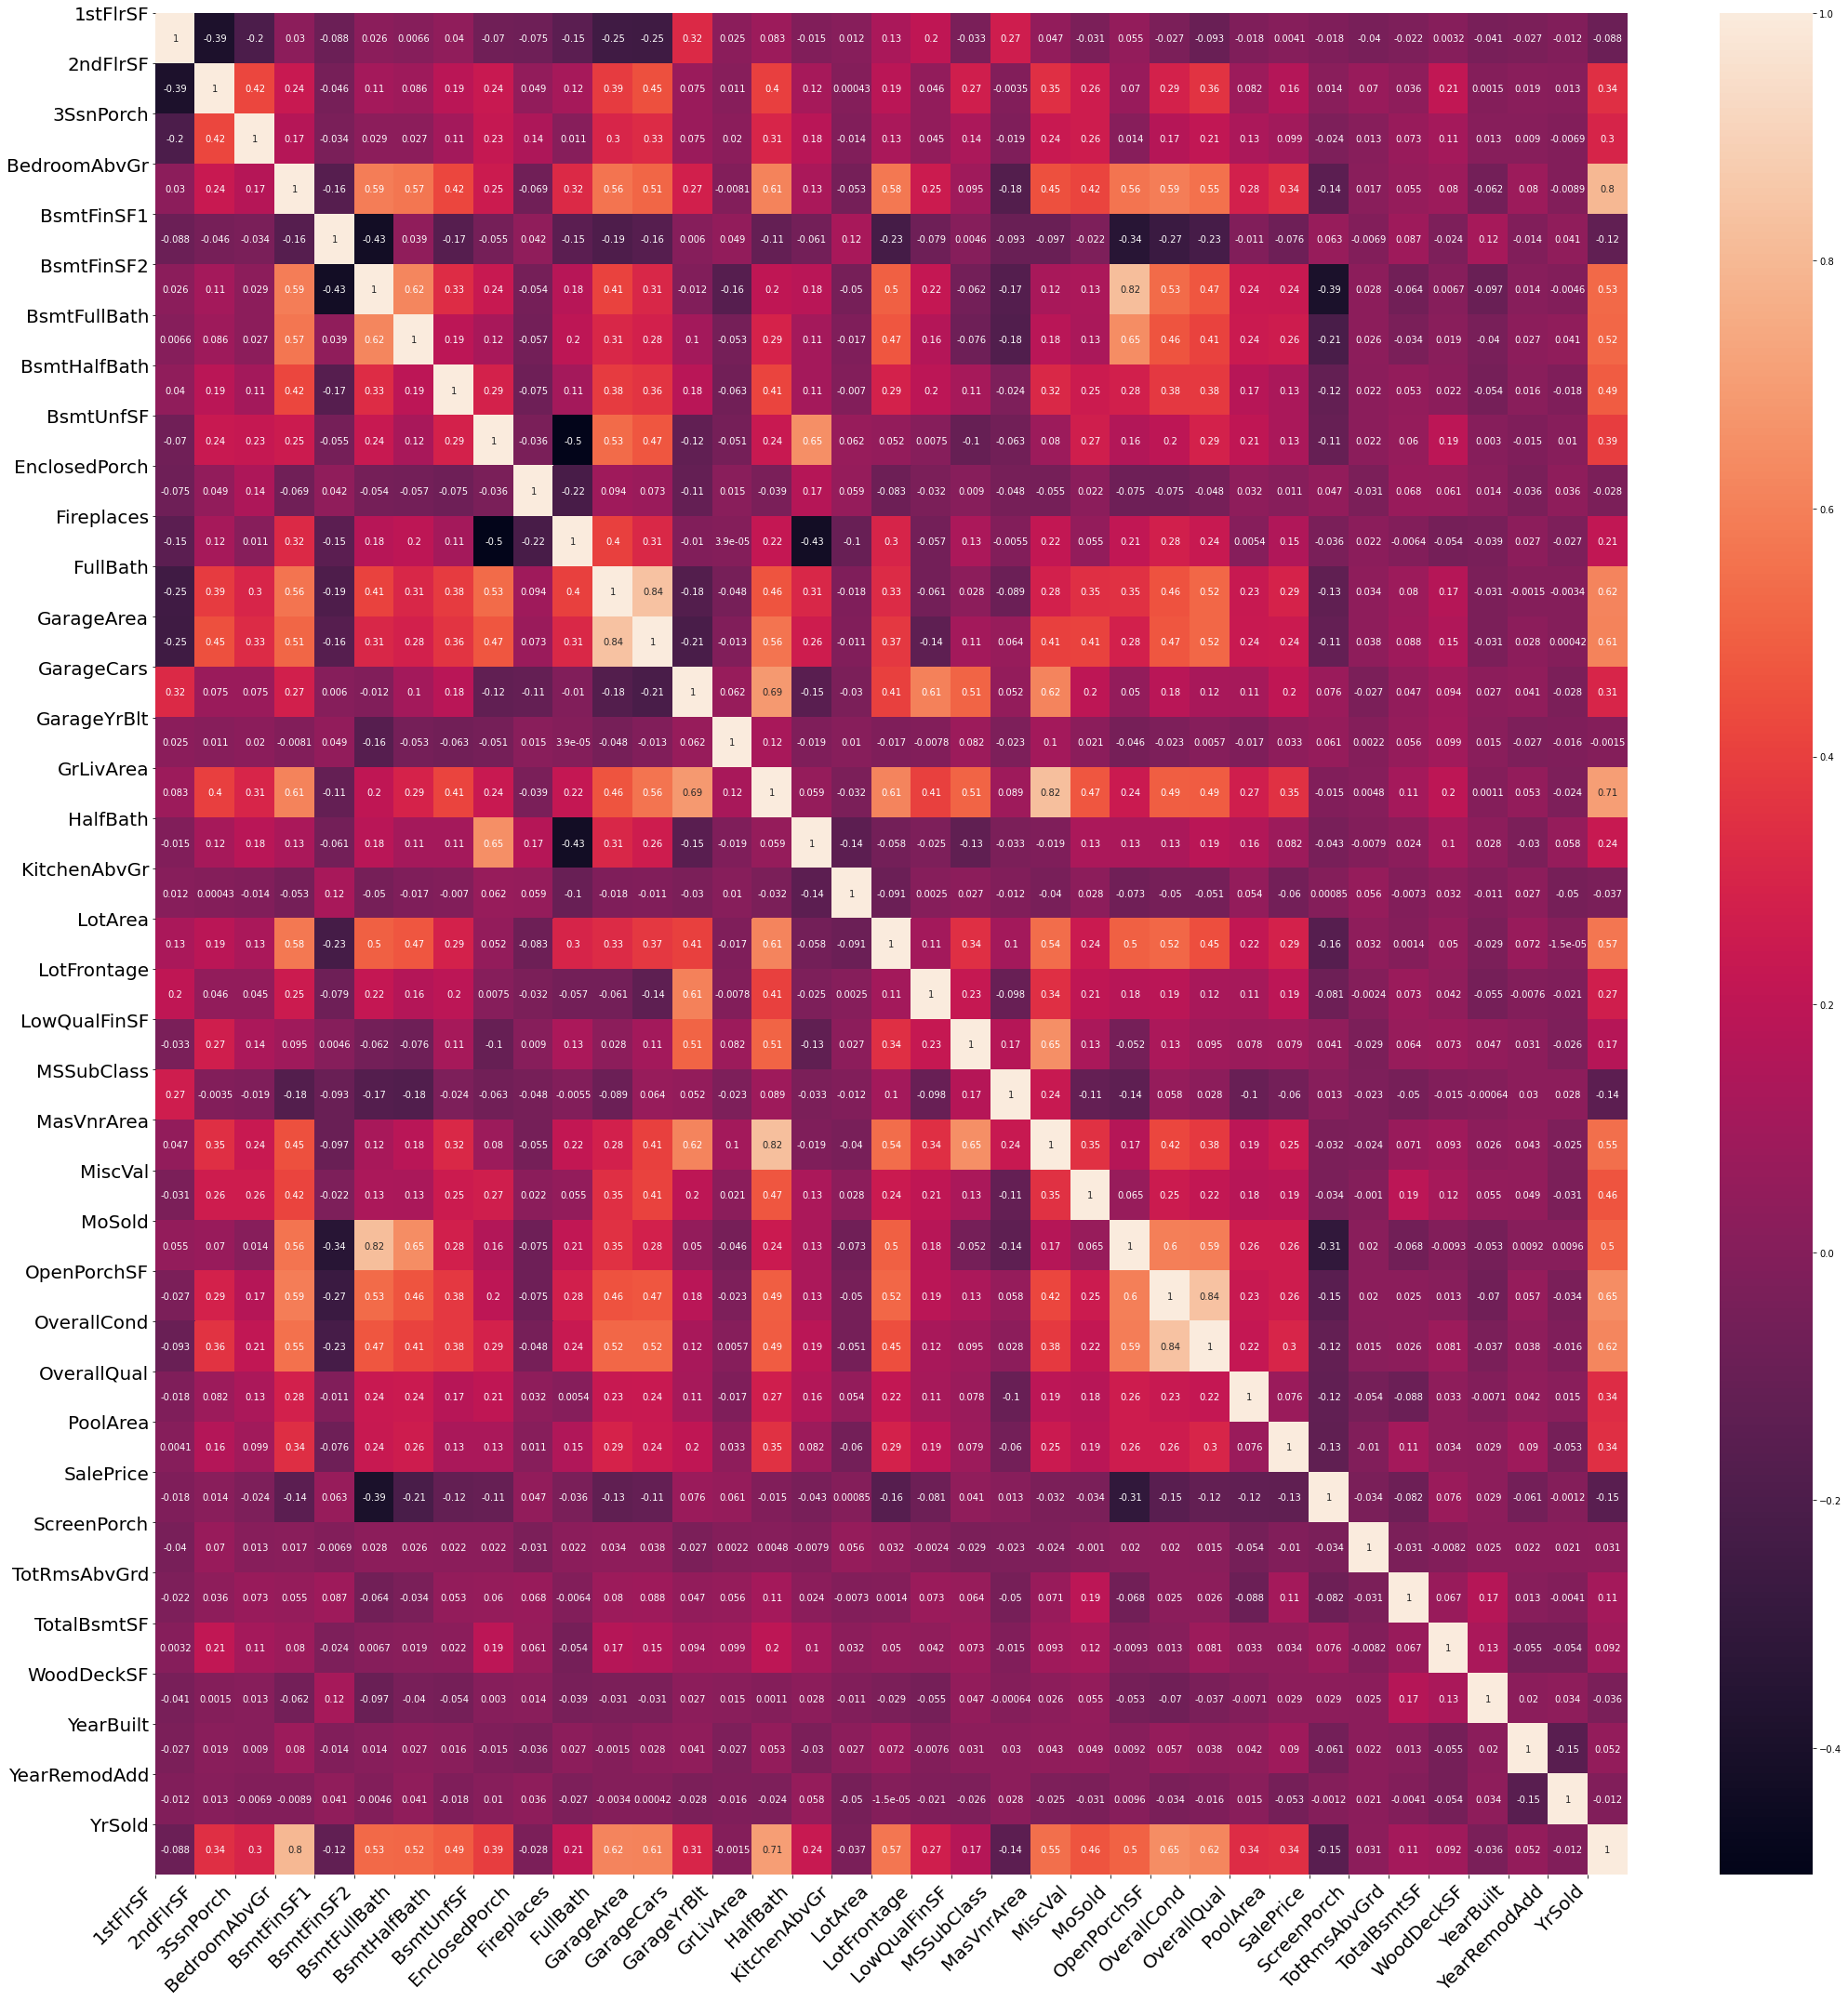

In [282]:
heatmap(df)

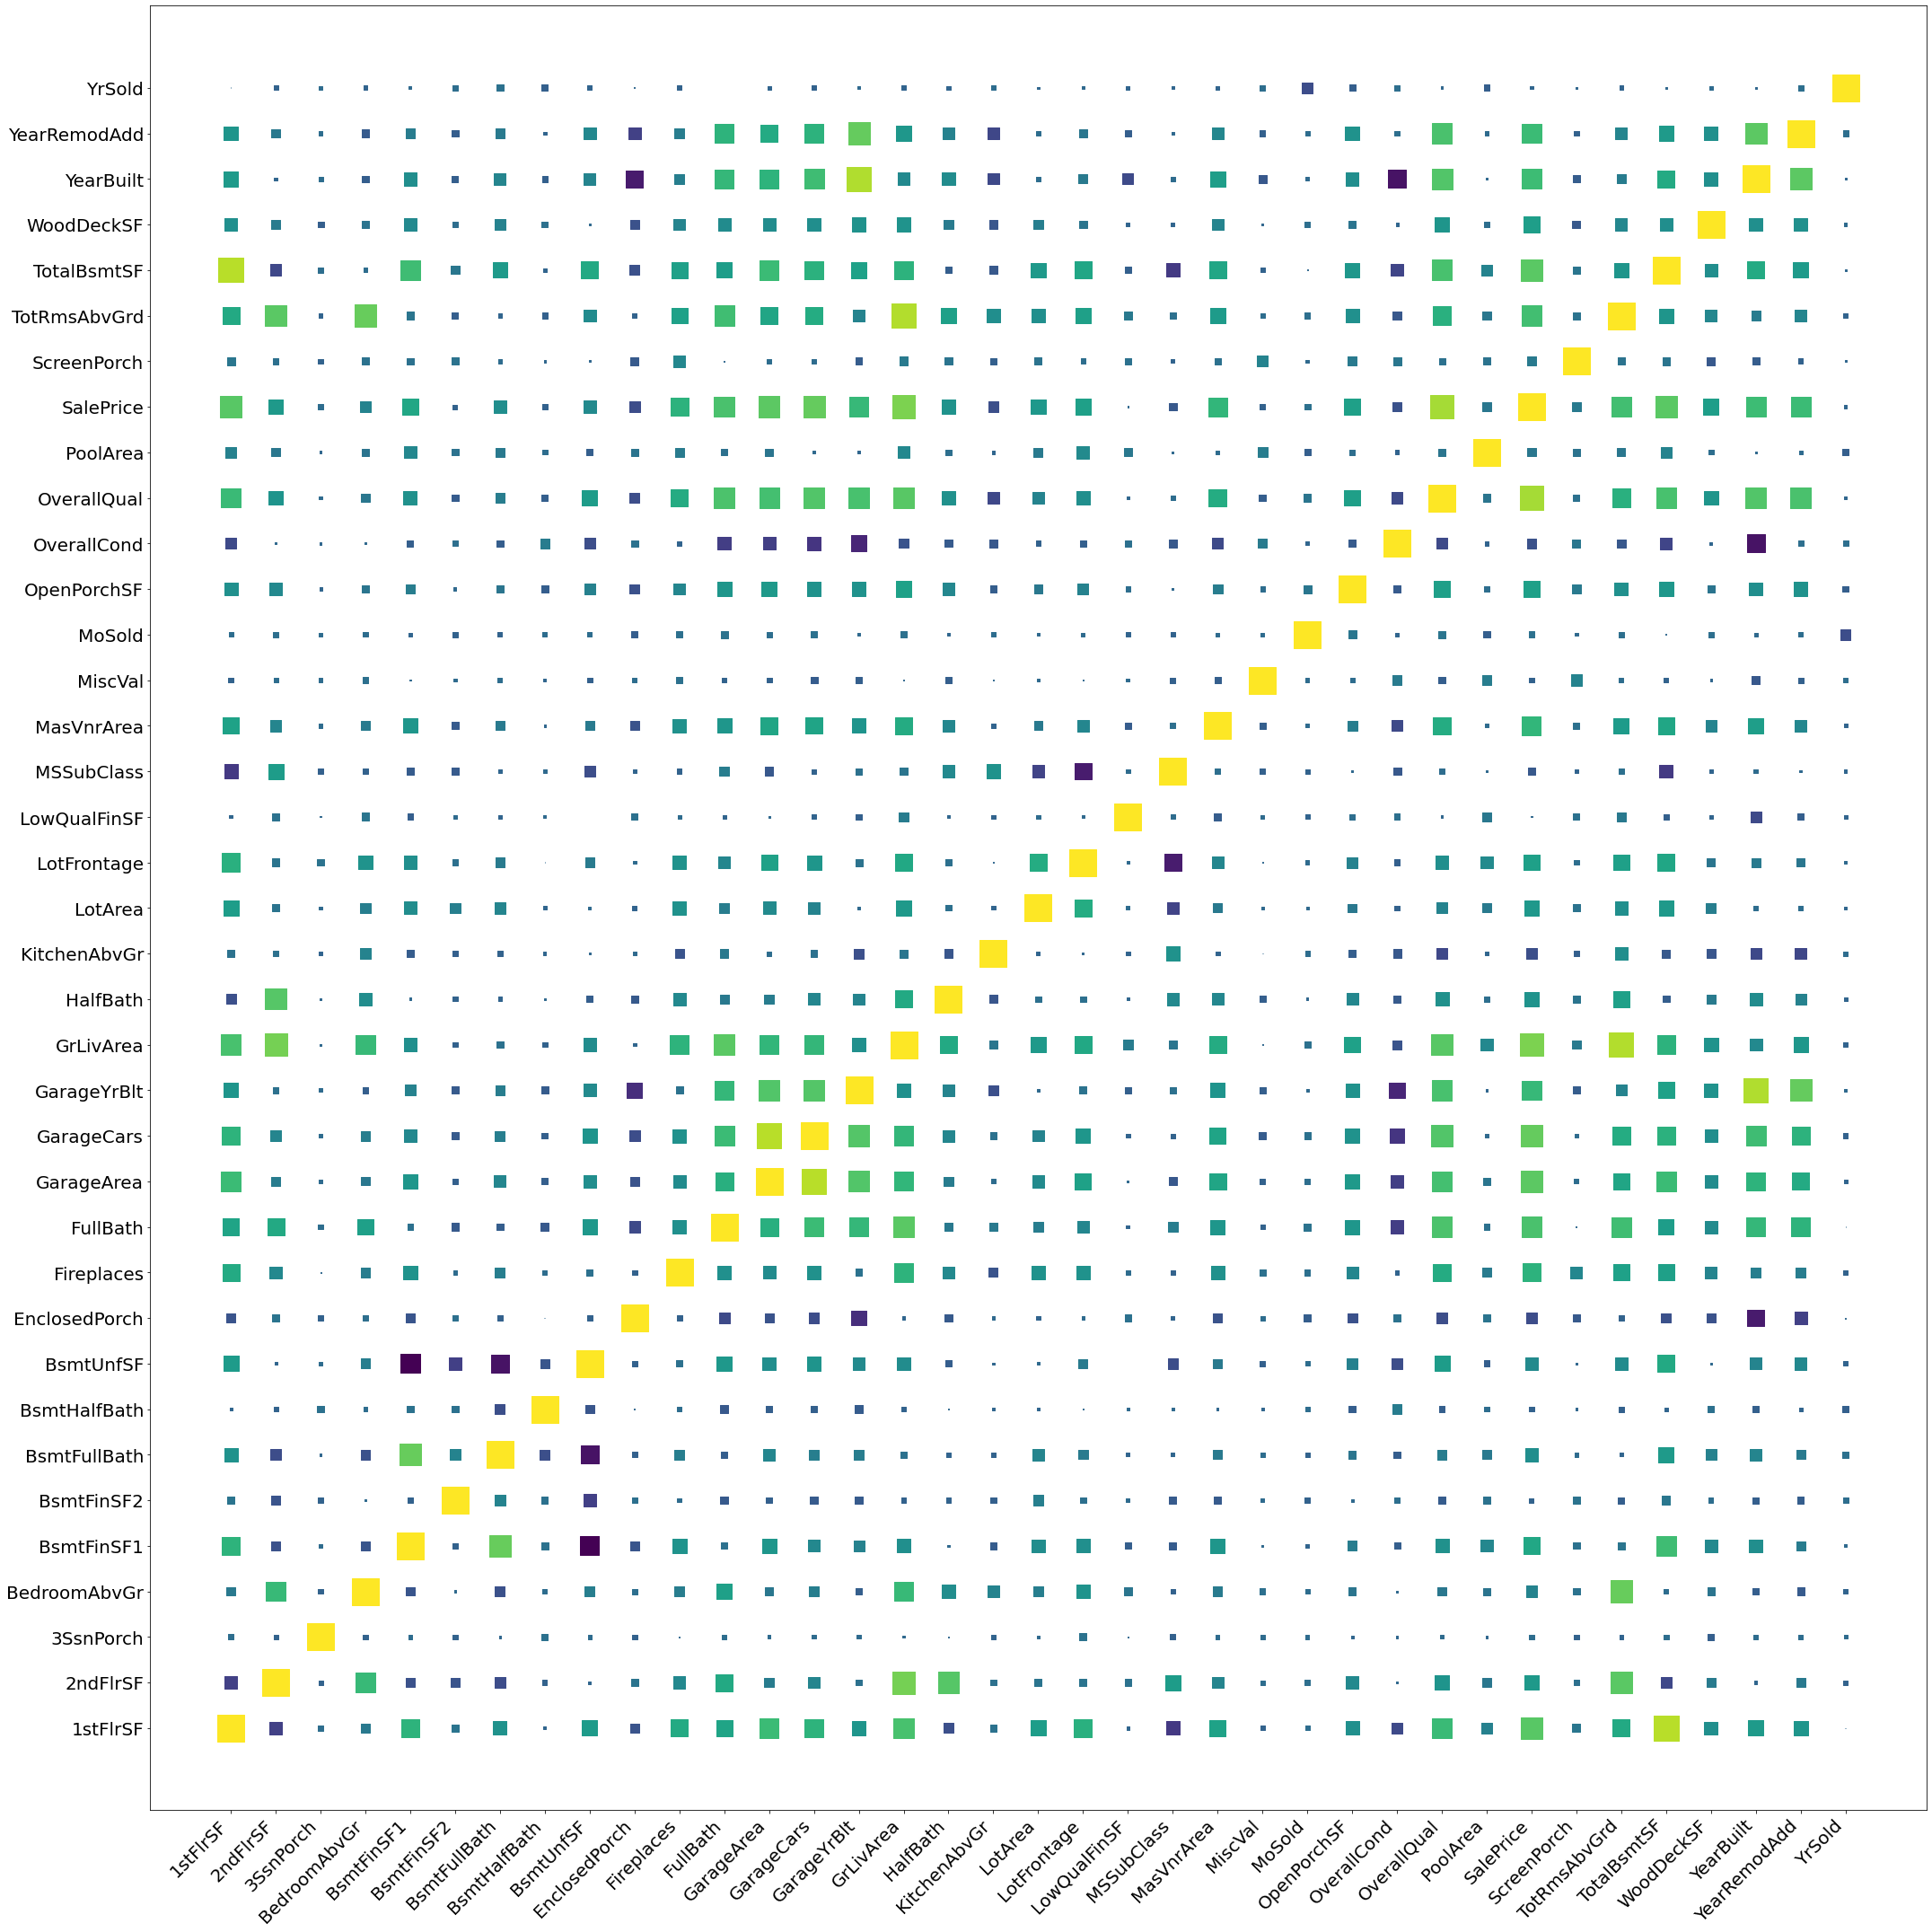

In [283]:
heatmap_square(df)

**<font color="blue">2.2. Methods for dimensionality reduction</font>**

In [15]:
PREPROCESSING = {'StandardScaler':std_scaler, 'MinMaxScaler': min_scaler,'scale':skl_scale}

In [16]:
DR = {'PCA':PCA, 'FactorAnalysis':FactorAnalysis, 'FastICA':FastICA}

In [17]:
# Sandardizing the features

def scaler(X_df, sc="StandardScaler" ,*args):
    if (sc=="StandardScaler" or sc=="MinMaxScaler"):
        X_train = X_df.values
        sc =  PREPROCESSING[sc]()
        X_train = sc.fit_transform(X_train)
        if len(args)>0: 
            X_test = sc.transform(args[0])
            return X_train, X_test
        else :
            return X_train, sc
    else:
        X_train = X_df.values
        X_train =  PREPROCESSING[sc](X_train)
        return X_train
        

In [18]:
# Compute the eigenvalues of a square matrix (covariance) and return sorted eigenvalues

def compute_eigenvalues(dataframe):
    X_df = dataframe.drop('SalePrice', 1)
    X, _ = scaler(X_df)
    X = np.cov(X.T)
    eigenvalues = np.linalg.eigvals(X)
    array = np.argsort(eigenvalues)
    return eigenvalues[array][::-1]

In [19]:
# return a dataframe with dim reduce

def dim_reduction(dataframe, method='PCA', n_components=36, random_state=42):
    X_df = dataframe.drop('SalePrice', 1)
    y_df = dataframe['SalePrice'].values
    X, _ = scaler(X_df)
    model = DR[method](n_components=n_components, random_state=random_state)
    array = model.fit_transform(X)
    array = np.c_[array, y_df]
    df = pd.DataFrame(data = array, columns=[f'component_{i+1}' for i in range(n_components)]+['SalePrice'])
    return df, model

**<font color="orange">Implement PCA</font>**

***Plot the eigenvalues***

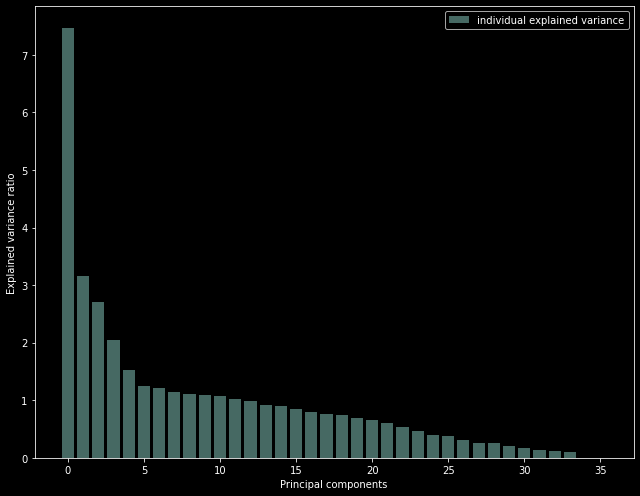

In [20]:
eigenvalues = compute_eigenvalues(df)
with plt.style.context('dark_background'):
    plt.figure(figsize=(9,7))
    plt.bar(range(36),
            eigenvalues, 
            alpha=0.5,
            align='center',
            label='individual explained variance'
    )
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

<h3>Explained variance ratio</h3>
<p>The explained variance tells us how much information (variance) can be attributed to
each of the principal components.</p>

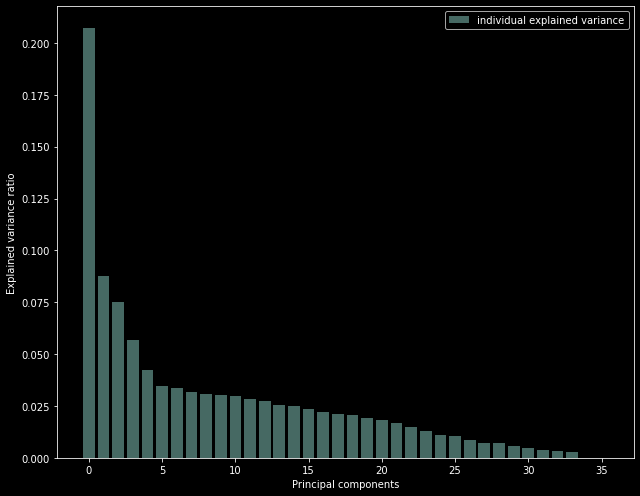

In [21]:
new_df, pca = dim_reduction(df)
explained_variance = pca.explained_variance_ratio_
with plt.style.context('dark_background'):
    plt.figure(figsize=(9,7))
    plt.bar(range(36), # 36 is the number of features
            explained_variance, 
            alpha=0.5,
            align='center',
            label='individual explained variance'
    )
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

<font color="#B533FF"> We have seen the eigenvalues is the same as the explained variances </font>

**<font color="orange"> Implement ICA</font>**

**<font color="orange">Implement Factorial Analysis</font>**

# 3. Modeling

**<font color="red"> CLASSIFICATION </font>**

In [22]:
class classification(nn.Module):
    # define nn
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(in_dim, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        X = self.fc3(X)
        X = self.softmax(X)

        return X

**<font color="red">LINEAR REGRESSION </font>**

In [23]:
class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.fc1 = nn.Linear(36, 1)
        #self.predict = nn.Linear(150, 1)
        
    def forward(self, x):
        output = self.fc1(x)
        #output = self.predict(output)
        return output

**<font color="red"> SUPPORT VECTOR REGRESSION </font>**

**<font color="red"> DECISION TREE </font>**

# 4. Training

In [24]:
def split_dataset(X, y, test_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

In [25]:
def convert2float(data, dtype = np.float32):
    dt = data.astype(np.float32)
    return dt

In [27]:
def convert2Tensor(array):
    return Variable(torch.from_numpy(convert2float(array)))

**<font color="red">LINEAR REGRESSION </font>**

In [28]:
state = True # change to True if you want to scale dataframe
scale_mth= "MinMaxScaler" # MinMaxScaler, StandardScaler, scale
if state:
    if scale_mth=="scale":
        df_scale = scaler(df, scale_mth)
    else:
        df_scale, sc = scaler(df, scale_mth)
    y = df_scale[:,-1]
    X = df_scale[:,:-1]
    X_train, X_test, y_train, y_test = split_dataset(X, y)
    X_train = convert2Tensor(X_train)
    X_test = convert2Tensor(X_test)
    y_train = convert2Tensor(y_train)
    y_test = convert2Tensor(y_test)
else:
    data = df.values
    y = data[:,-1]
    X = data[:,:-1]
    X_train, X_test, y_train, y_test = split_dataset(X, y)
    X_train = convert2Tensor(X_train)
    X_test = convert2Tensor(X_test)
    y_train = convert2Tensor(y_train)
    y_test = convert2Tensor(y_test)

<font color="orange">load Model,loss and optimizer</font>

In [51]:
# minmascaler sklearn preprocessing (need view) apply to dataframe
net = Regressor() 
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=1e-4, momentum=0.5)

<font color="orange">Apply MinMaxScaler to the entire data and split after</font>

Convert data to tensor 

In [52]:
epochs = 3000
loss_  = []
for epoch in range(epochs):
    optimizer.zero_grad()
    output = net(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    loss_.append(loss.item())
    if (epoch+1) % 100 == 0:
        print(f'Epoch[{epoch+1}/{epochs}], loss: {loss.item():.6f}')

/home/frederic/.local/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([896])) that is different to the input size (torch.Size([896, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch[100/3000], loss: 0.292723
Epoch[200/3000], loss: 0.207021
Epoch[300/3000], loss: 0.148178
Epoch[400/3000], loss: 0.107772
Epoch[500/3000], loss: 0.080024
Epoch[600/3000], loss: 0.060964
Epoch[700/3000], loss: 0.047868
Epoch[800/3000], loss: 0.038867
Epoch[900/3000], loss: 0.032678
Epoch[1000/3000], loss: 0.028418
Epoch[1100/3000], loss: 0.025482
Epoch[1200/3000], loss: 0.023456
Epoch[1300/3000], loss: 0.022055
Epoch[1400/3000], loss: 0.021082
Epoch[1500/3000], loss: 0.020404
Epoch[1600/3000], loss: 0.019928
Epoch[1700/3000], loss: 0.019591
Epoch[1800/3000], loss: 0.019349
Epoch[1900/3000], loss: 0.019173
Epoch[2000/3000], loss: 0.019042
Epoch[2100/3000], loss: 0.018942
Epoch[2200/3000], loss: 0.018863
Epoch[2300/3000], loss: 0.018799
Epoch[2400/3000], loss: 0.018746
Epoch[2500/3000], loss: 0.018699
Epoch[2600/3000], loss: 0.018658
Epoch[2700/3000], loss: 0.018619
Epoch[2800/3000], loss: 0.018584
Epoch[2900/3000], loss: 0.018550
Epoch[3000/3000], loss: 0.018517


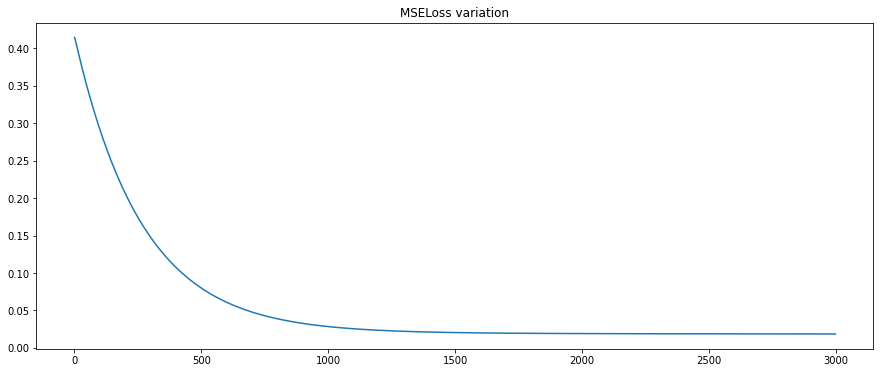

In [53]:
fig, ax = plt.subplots(figsize=(15,6))
plt.plot(loss_)
ax.set_title('MSELoss variation')
plt.show()

**<font color="red">CLASSIFICATION </font>**

# 5. Evaluation

***Recall***


$
    \text{y} = \mathbf{\theta }. x
$

$
\hat{\boldsymbol{\theta}} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}
$

$
    \hat{\text{y}} = \mathbf{\hat{\theta }}. x
$


$
\text{MSE}(\mathbf{X}, h_{\boldsymbol{\theta}}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{(\boldsymbol{\theta}^T \mathbf{x}^{(i)} - \hat{y}^{(i)})^2}
$



**<font color="grey">PREDICTION ON THE TEST SET</font>**

In [54]:
net.eval()
with torch.no_grad():
    predict = net(X_test)
predict = predict.data.numpy() # equiv predict.detach().numpy()

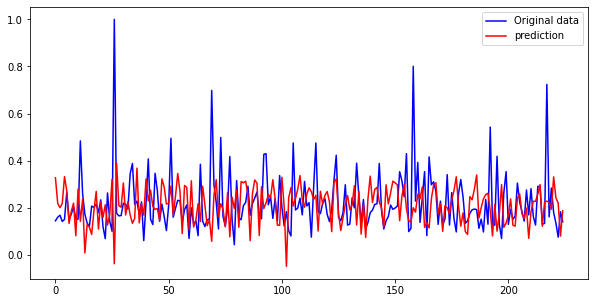

In [55]:
fig = plt.figure(figsize=(10, 5))
plt.plot(y_test.numpy(),color='blue', label='Original data')
plt.plot(predict, color='red', label='prediction')
plt.legend() 
plt.show()

In [78]:
def performance_(y_test, predict):
    y_test = y_test.numpy()
    m = y_test.shape[0]
    result = np.sqrt((1/m)*np.sum(np.power(predict-y_test,2)))
    return result

In [79]:
performance_(y_test, predict)

2.187374376353163

# This prediction is good because we want MSE is as minimum as possible

# 6. Inference

In [60]:
house_test = load_csv_data(csv_file="test.csv")
house_test.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal


In [61]:
house_train_columns = set(columnsAffectPrices)
house_test_columns = set(list(house_test.columns))
intersection = list(house_test_columns.intersection(house_train_columns))
len(intersection)

37

In [62]:
house_test_red = reduiceDataframe(house_test, intersection)
house_test_red = dropna_value(house_test_red)
house_test_red.head()

,3SsnPorch,1stFlrSF,YearRemodAdd,BsmtUnfSF,MasVnrArea,2ndFlrSF,GarageArea,MiscVal,BsmtFullBath,ScreenPorch,TotRmsAbvGrd,OverallQual,Id,Fireplaces,LotFrontage,GarageCars,OpenPorchSF,FullBath,OverallCond,MSSubClass,KitchenAbvGr,YearBuilt,LotArea,YrSold,BsmtFinSF2,BsmtHalfBath,GrLivArea,GarageYrBlt,BsmtFinSF1,MoSold,HalfBath,EnclosedPorch,PoolArea,TotalBsmtSF,LowQualFinSF,BedroomAbvGr,WoodDeckSF
0,0,896,1961,270.0,0.0,0,730.0,0,0.0,120,5,5,1461,0,80.0,1.0,0,1,6,20,1,1961,11622,2010,144.0,0.0,896,1961.0,468.0,6,0,0,0,882.0,0,2,140
1,0,1329,1958,406.0,108.0,0,312.0,12500,0.0,0,6,6,1462,0,81.0,1.0,36,1,6,20,1,1958,14267,2010,0.0,0.0,1329,1958.0,923.0,6,1,0,0,1329.0,0,3,393
2,0,928,1998,137.0,0.0,701,482.0,0,0.0,0,6,5,1463,1,74.0,2.0,34,2,5,60,1,1997,13830,2010,0.0,0.0,1629,1997.0,791.0,3,1,0,0,928.0,0,3,212
3,0,926,1998,324.0,20.0,678,470.0,0,0.0,0,7,6,1464,1,78.0,2.0,36,2,6,60,1,1998,9978,2010,0.0,0.0,1604,1998.0,602.0,6,1,0,0,926.0,0,3,360
4,0,1280,1992,1017.0,0.0,0,506.0,0,0.0,144,5,8,1465,0,43.0,2.0,82,2,5,120,1,1992,5005,2010,0.0,0.0,1280,1992.0,263.0,1,0,0,0,1280.0,0,2,0


In [63]:
IDENTITY = list(house_test_red["Id"])
id2SaleCondition = dict()
for idt, s_cond in zip(house_test['Id'], house_test['SaleCondition']):
    if idt in IDENTITY:
        id2SaleCondition[idt] = s_cond
id2SaleCondition

{1461: 'Normal',
 1462: 'Normal',
 1463: 'Normal',
 1464: 'Normal',
 1465: 'Normal',
 1466: 'Normal',
 1468: 'Normal',
 1469: 'Normal',
 1470: 'Normal',
 1471: 'Normal',
 1472: 'Normal',
 1473: 'Normal',
 1474: 'Normal',
 1475: 'Normal',
 1476: 'Partial',
 1477: 'Partial',
 1478: 'Normal',
 1479: 'Normal',
 1480: 'Normal',
 1481: 'Normal',
 1482: 'Normal',
 1483: 'Normal',
 1484: 'Normal',
 1485: 'Normal',
 1486: 'Normal',
 1487: 'Normal',
 1488: 'Normal',
 1489: 'Partial',
 1490: 'Normal',
 1491: 'Normal',
 1492: 'Normal',
 1493: 'Abnorml',
 1494: 'Normal',
 1495: 'Normal',
 1496: 'Normal',
 1497: 'Normal',
 1498: 'Normal',
 1499: 'Normal',
 1500: 'Normal',
 1503: 'Partial',
 1504: 'Normal',
 1505: 'Normal',
 1507: 'Normal',
 1509: 'Normal',
 1510: 'Normal',
 1511: 'Normal',
 1512: 'Normal',
 1515: 'Normal',
 1516: 'Normal',
 1517: 'Normal',
 1518: 'Normal',
 1519: 'Normal',
 1521: 'Normal',
 1522: 'Normal',
 1523: 'Normal',
 1524: 'Normal',
 1525: 'Normal',
 1526: 'Abnorml',
 1527: '

In [64]:
output_df = house_test_red.drop('Id', axis=1)

In [65]:
df_test_scale, _ = scaler(output_df, "MinMaxScaler")
ev_test = convert2Tensor(df_test_scale)
ev_predict = net(ev_test)

In [66]:
# insert prediction in the last columns of df_test_scale
ev_predict = ev_predict.detach().numpy()
final = np.c_[df_test_scale, ev_predict]
final.shape

(1146, 37)

In [67]:
submission_data = sc.inverse_transform(final)[:,-1] # Apply the scaler sc that we use above when scale df
house_test_red['SalePrice'] = submission_data
house_test_red.head()

,3SsnPorch,1stFlrSF,YearRemodAdd,BsmtUnfSF,MasVnrArea,2ndFlrSF,GarageArea,MiscVal,BsmtFullBath,ScreenPorch,TotRmsAbvGrd,OverallQual,Id,Fireplaces,LotFrontage,GarageCars,OpenPorchSF,FullBath,OverallCond,MSSubClass,KitchenAbvGr,YearBuilt,LotArea,YrSold,BsmtFinSF2,BsmtHalfBath,GrLivArea,GarageYrBlt,BsmtFinSF1,MoSold,HalfBath,EnclosedPorch,PoolArea,TotalBsmtSF,LowQualFinSF,BedroomAbvGr,WoodDeckSF,SalePrice
0,0,896,1961,270.0,0.0,0,730.0,0,0.0,120,5,5,1461,0,80.0,1.0,0,1,6,20,1,1961,11622,2010,144.0,0.0,896,1961.0,468.0,6,0,0,0,882.0,0,2,140,144732.722724
1,0,1329,1958,406.0,108.0,0,312.0,12500,0.0,0,6,6,1462,0,81.0,1.0,36,1,6,20,1,1958,14267,2010,0.0,0.0,1329,1958.0,923.0,6,1,0,0,1329.0,0,3,393,74701.904763
2,0,928,1998,137.0,0.0,701,482.0,0,0.0,0,6,5,1463,1,74.0,2.0,34,2,5,60,1,1997,13830,2010,0.0,0.0,1629,1997.0,791.0,3,1,0,0,928.0,0,3,212,188514.566120
3,0,926,1998,324.0,20.0,678,470.0,0,0.0,0,7,6,1464,1,78.0,2.0,36,2,6,60,1,1998,9978,2010,0.0,0.0,1604,1998.0,602.0,6,1,0,0,926.0,0,3,360,175502.656145
4,0,1280,1992,1017.0,0.0,0,506.0,0,0.0,144,5,8,1465,0,43.0,2.0,82,2,5,120,1,1992,5005,2010,0.0,0.0,1280,1992.0,263.0,1,0,0,0,1280.0,0,2,0,191013.315863


In [68]:
house_test_red['SaleCondition'] = house_test_red['Id'].map(id2SaleCondition)
house_test_red.head()

,3SsnPorch,1stFlrSF,YearRemodAdd,BsmtUnfSF,MasVnrArea,2ndFlrSF,GarageArea,MiscVal,BsmtFullBath,ScreenPorch,TotRmsAbvGrd,OverallQual,Id,Fireplaces,LotFrontage,GarageCars,OpenPorchSF,FullBath,OverallCond,MSSubClass,KitchenAbvGr,YearBuilt,LotArea,YrSold,BsmtFinSF2,BsmtHalfBath,GrLivArea,GarageYrBlt,BsmtFinSF1,MoSold,HalfBath,EnclosedPorch,PoolArea,TotalBsmtSF,LowQualFinSF,BedroomAbvGr,WoodDeckSF,SalePrice,SaleCondition
0,0,896,1961,270.0,0.0,0,730.0,0,0.0,120,5,5,1461,0,80.0,1.0,0,1,6,20,1,1961,11622,2010,144.0,0.0,896,1961.0,468.0,6,0,0,0,882.0,0,2,140,144732.722724,Normal
1,0,1329,1958,406.0,108.0,0,312.0,12500,0.0,0,6,6,1462,0,81.0,1.0,36,1,6,20,1,1958,14267,2010,0.0,0.0,1329,1958.0,923.0,6,1,0,0,1329.0,0,3,393,74701.904763,Normal
2,0,928,1998,137.0,0.0,701,482.0,0,0.0,0,6,5,1463,1,74.0,2.0,34,2,5,60,1,1997,13830,2010,0.0,0.0,1629,1997.0,791.0,3,1,0,0,928.0,0,3,212,188514.566120,Normal
3,0,926,1998,324.0,20.0,678,470.0,0,0.0,0,7,6,1464,1,78.0,2.0,36,2,6,60,1,1998,9978,2010,0.0,0.0,1604,1998.0,602.0,6,1,0,0,926.0,0,3,360,175502.656145,Normal
4,0,1280,1992,1017.0,0.0,0,506.0,0,0.0,144,5,8,1465,0,43.0,2.0,82,2,5,120,1,1992,5005,2010,0.0,0.0,1280,1992.0,263.0,1,0,0,0,1280.0,0,2,0,191013.315863,Normal


In [69]:
save_csv(house_test_red, "predictUnseenData")
torch.save(net.state_dict(), 'checkpoint/house_price_prediction.pth')